In [17]:
import torch
print("是否可用：", torch.cuda.is_available())        # 查看GPU是否可用
print("GPU数量：", torch.cuda.device_count())        # 查看GPU数量
print("torch方法查看CUDA版本：", torch.version.cuda)  # torch方法查看CUDA版本
print("GPU索引号：", torch.cuda.current_device())    # 查看GPU索引号
print("GPU名称：", torch.cuda.get_device_name(0))    # 根据索引号得到GPU名称

是否可用： True
GPU数量： 1
torch方法查看CUDA版本： 12.4
GPU索引号： 0
GPU名称： NVIDIA GeForce RTX 4060 Laptop GPU


In [18]:
%pip install -Uq diffusers ftfy accelerate

Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install -Uq git+https://github.com/huggingface/transformers 

Note: you may need to restart the kernel to use updated packages.


In [20]:
import torch
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
)

# We'll use a couple of demo images later in the notebook


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [21]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [22]:
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 12.51it/s]


100%|██████████| 35/35 [11:11<00:00, 19.17s/it]


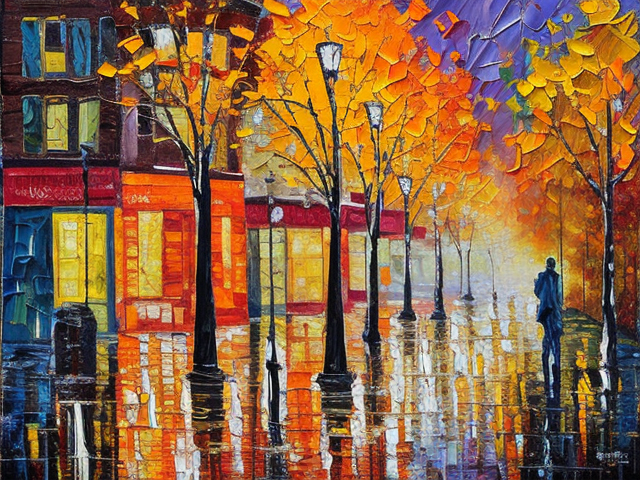

In [23]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",  # What to generate
    negative_prompt="Oversaturated, blurry, low quality",  # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

100%|██████████| 35/35 [06:39<00:00, 11.42s/it]


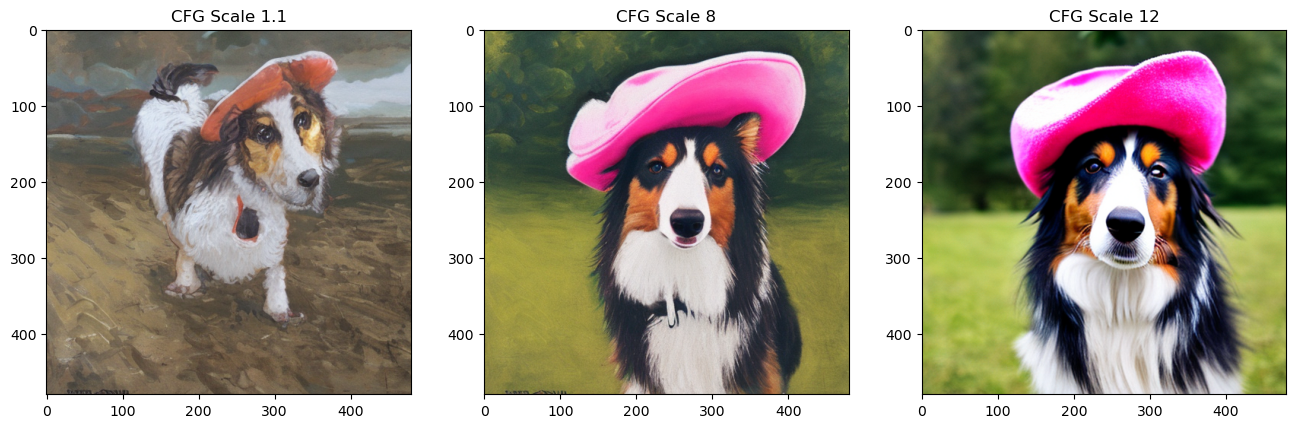

In [24]:

cfg_scales = [1.1, 8, 12] #@param
prompt = "A collie with a pink hat" #@param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

100%|██████████| 35/35 [10:53<00:00, 18.66s/it]


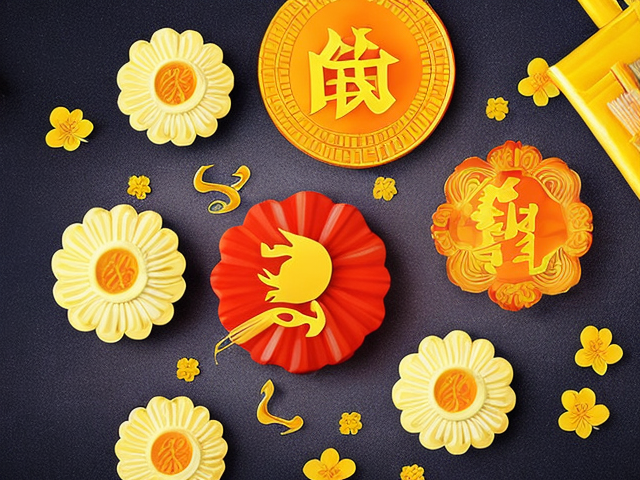

In [25]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Happy Mid-autumn Festival",  # What to generate
    negative_prompt="Oversaturated, blurry, low quality",  # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0] 

In [26]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


In [27]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


In [28]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [34]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents


UNet output shape: torch.Size([1, 4, 64, 64])


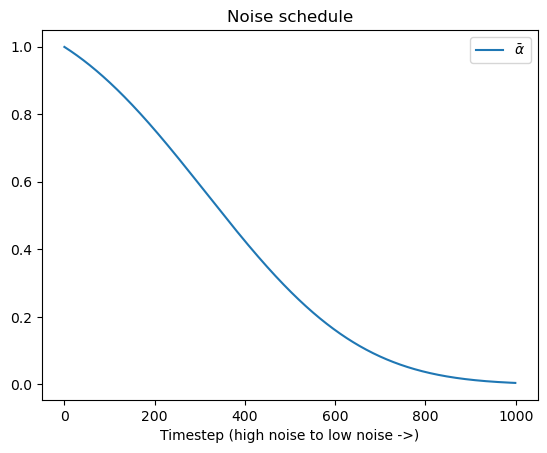

In [35]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.30.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



100%|██████████| 50/50 [13:58<00:00, 16.77s/it]


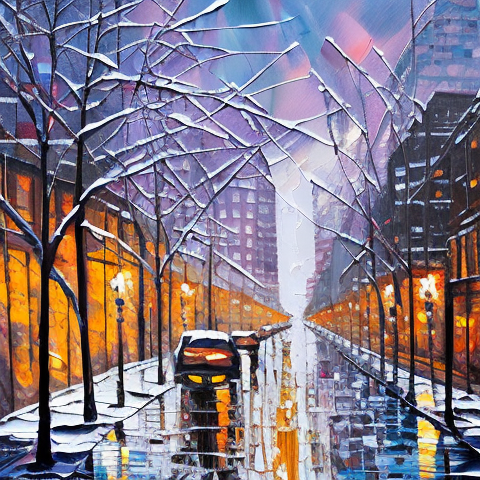

In [36]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

In [38]:
guidance_scale = 8 #@param
num_inference_steps = 30 #@param
prompt = "Beautiful picture of a wave breaking" #@param
negative_prompt = "zoomed in, blurry, oversaturated, warped" #@param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

c:\Users\Jason\anaconda3\envs\wtorch\Lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:283: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
